In [65]:
import numpy as np
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
from numpy.linalg import inv

%matplotlib inline
%precision 4

'%.4f'

# 1. Base MAB Class


In [28]:
class MAB(ABC):
    """
    Base class for a MAB instance
    
    Parameters
    ----------
    num_arms : int
        Number of arms.
    """
    def __init__(self, num_arms):
        self.num_arms = num_arms
        
    @abstractmethod
    def play(self, context=None):
        """
        Play an arm
        
        Parameters
        ----------        
        context : float numpy.ndarray, shape = (n_arms, n_dims)
            An array of context vectors.
            e-greedy and UCB bandits have context = None. 
        Returns
        -------
        arm : int
            Index of arm.
        """
        self.context = context

    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Update arm parameters
        
        Parameters
        ----------
        arm : int
            Index of arm.
        
        reward : float
            Reward received from the arm.
        
        context : float numpy.ndarray, shape = (n_arms, n_dims)
            An array of context vectors.
            e-greedy and UCB bandits have context = None. 
        """
        # Update parameters
        self.arm = arm
        self.reward = reward
        self.context = context

## 2. Load dataset
The dataset `dataset.txt` contains 10,000 instances of users and news articles. Each instance comprises 102 space-delimited columns of integers:
 - Column 1: The arm played by a uniformly-random policy.
 - Column 2: The reward received from the arm played.
 - Columns 3-102: 100-dim flattened context vectors; 10 features per arm for 10 arms.


In [57]:
# load dataset and initialize arms, rewards and contexts vectors
data = np.loadtxt("dataset.txt")
chosen_arms = data[:,0]
rewards = data[:,1]
contexts = data[:,2:]

chosen_arms = chosen_arms.astype(int)
rewards = rewards.astype(float)
contexts = contexts.astype(float)
num_arms = len(np.unique(chosen_arms))
print("Number of arms is:", num_arms)
num_events = len(contexts)
dim = int(len(contexts[0])/num_arms)
print("Number of contexts for each arm is:", dim)
contexts = contexts.reshape(num_events, num_arms, dim)
print("Context vectors of 10 arms for the first instance is:")
print(contexts[0])

Number of arms is: 10
Number of contexts for each arm is: 10
Context vectors of 10 arms for the first instance is:
[[ 5.  0.  0. 37.  6.  0.  0.  0.  0. 25.]
 [ 0.  0.  7.  1.  0.  0.  0. 13.  2.  0.]
 [ 0.  8.  0.  0.  0. 15. 29.  1.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  3.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  4.  0.  0.  0.  0.  0.  0.]
 [ 0.  5.  2.  7.  0.  0.  0.  0. 11.  0.]
 [ 5.  0.  0.  0.  0.  0.  0.  3.  2.  0.]
 [ 0.  0.  0.  1.  2. 47.  0.  0.  1.  0.]
 [ 0.  0.  1.  3.  0.  0. 17. 30.  4.  0.]]


## Off-policy evaluation

In [53]:
def OPE(mab, arms, rewards, contexts, n_rounds=10000):
    """
    Offline evaluation of a MAB policy
    
    Parameters
    ----------
    mab : MAB 
        MAB instance to evaluate.
    
    arms : int numpy.ndarray
        Array containing the history of pulled arms.
    
    rewards : float numpy.ndarray
        Array containing the history of rewards.
    
    contexts : float numpy.ndarray
        History of contexts presented to arms. 
        The 0-th axis indexes the events in the history.
        Each event consists of 10 context vectors for the arms.
        
    n_rounds : int
        Number of matching events to evaluate the MAB on. 
    
    Returns
    -------
    out : float numpy.ndarray
        Rewards for the matching events.
    """
    t = 0         # current round
    R = []        # total reward
    history = []  # used historical events
    
    n_events = arms.shape[0]
    for i in range(n_events):
        if t == n_rounds:
            break
        chosen_arm = mab.play(contexts[i])
        # update parameters and play only when chosen arm from bandit matches data
        if chosen_arm == arms[i]:
            R.append(rewards[i])
            history.append([arms[i], rewards[i], contexts[i]])
            mab.update(arms[i], rewards[i], contexts[i])
            t += 1

    out = np.array(R)        
    return out 

# Non-contextual MABs

### I. ε-greedy

In [58]:
class EpsGreedy(MAB):
    """Epsilon-Greedy multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms

    epsilon : float
        Explore probability. Must be in the interval [0, 1].

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    # initialise values and raise input errors
    def __init__(self, num_arms, epsilon, q0=np.inf):  
        super().__init__(num_arms)
        self.epsilon = epsilon
        self.q = np.full(num_arms, q0)
        self.rewards = np.zeros(num_arms)  # total rewards per arm
        self.clicks = np.zeros(num_arms)   # number of times arm is chosen
    
    # ε-greedy policy
    def play(self, context=None):
        super().play(context)
        if np.random.rand() < self.epsilon:
            arm = np.random.randint(0, self.num_arms)
        else:
            arm = np.random.choice(np.where(self.q==max(self.q))[0])
        return arm+1
    
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.clicks[arm] += 1
        self.rewards[arm] += self.reward
        self.q[arm] = self.rewards[arm]/self.clicks[arm]
        

In [74]:
mab = EpsGreedy(num_arms, 0.1) 
results_EpsGreedy = OPE(mab, chosen_arms, rewards, contexts,)
print('Epsilon-greedy average reward is: %.4f' % np.mean(results_EpsGreedy))

Epsilon-greedy average reward is: 0.2309


### II. Upper Confidence Bound (UCB)

In [54]:
class UCB(MAB):
    """Upper Confidence Bound (UCB) multi-armed bandit

    Parameters
    ----------
    n_arms : int
        Number of arms.

    rho : float
        Positive real explore-exploit parameter.

    Q0 : float, default=np.inf
        Initial value for the arms.
    """
    def __init__(self, n_arms, rho, Q0=np.inf):
        super().__init__(n_arms)
        if not rho > 0:
            raise ValueError("`rho` must be positive")
        if not (type(rho) == float and np.isreal(rho)):
            raise TypeError("`rho` must be real float")
        if not type(Q0) == float :
            raise TypeError("`Q0` must be a float number or default value 'np.inf'")
            
        self.rho = rho
        self.q = np.full(n_arms, Q0)
        self.rewards = np.zeros(n_arms)  
        self.avg_rewards = np.zeros(n_arms)
        self.clicks = np.zeros(n_arms)
        self.round = 0        # to count the number of round played
    
    def play(self, context=None):
        super().play(context)
        self.round += 1
        self.q = np.where(self.clicks != 0, self.avg_rewards + np.sqrt(self.rho * np.log10(self.round) / self.clicks), self.q)

        arm = break_tie(self.q)
        
        return int(arm)
        
    def update(self, arm, reward, context=None):
        super().update(arm, reward, context)
        self.clicks[arm] += 1
        self.rewards[arm] += reward
        self.avg_rewards[arm] = self.rewards[arm]/ self.clicks[arm]
        

In [9]:
# warning control
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [10]:
mab = UCB(num_arms, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts,)
print('UCB average reward', np.mean(results_UCB))


UCB average reward 0.18657453109575517


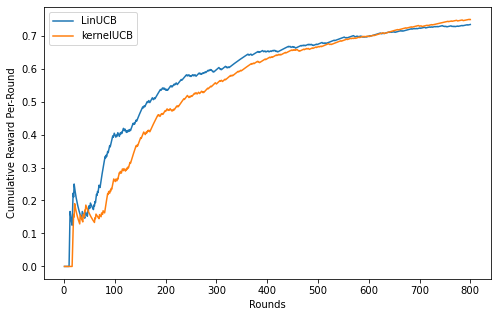

In [20]:
#  place holder code
best_lin_results, best_ker_results, round_list = [], [], []        # create lists for results
n_rounds = 800                                                     # the total number of rounds 
best_lin_sum, best_ker_sum = 0, 0                                  # set the initial reward sum

best_lin_mab = LinUCB(10, 10, best_alpha)
best_results_LinUCB = offlineEvaluate(best_lin_mab, arms, rewards, contexts,800)

# run UCB algorithms
best_kernel_mab = KernelUCB(10, 10, best_gamma, best_eta , rbf_kernel)
best_results_KernelUCB = offlineEvaluate(best_kernel_mab, arms, rewards, contexts, 800)

for n_round in range(1, n_rounds + 1):
    best_lin_sum += best_results_LinUCB[n_round-1] 
    best_ker_sum += best_results_KernelUCB[n_round-1]
    
    # append ccumulative rewards
    best_lin_results.append(best_lin_sum/n_round)
    best_ker_results.append(best_ker_sum/n_round)
    round_list.append(n_round)

# plot 
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(round_list, best_lin_results, label = "LinUCB")
plt.plot(round_list, best_ker_results, label = "kernelUCB")

plt.ylabel('Cumulative Reward Per-Round')
plt.xlabel('Rounds')
plt.legend()
plt.show()